<h1>Importing necessary libraries</h1>

In [285]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import nltk

# Packages for data preparation

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modelling

from keras import models
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.preprocessing import sequence
from keras.layers import Dense, Flatten, Activation, Dropout
from keras import regularizers

from sklearn.metrics import confusion_matrix

<h1>Data Loading into Pandas Data Frames</h1>

In [286]:
df = pd.read_csv("tweets.csv")
df.head()

,Tweet,Label
0,"When this India tour of Australia started, I k...",NR
1,US to help Iraq build base for Mosul push - Th...,NR
2,What @thetimes didn't know is Taqiya (lies) is...,NR
3,#WilayatAlFallujah\n\nNew Video : The Knights ...,R
4,US Defense Secretary Carter in Baghdad to disc...,NR


In [287]:
def get_missings(df):
    labels,values = list(),list()
    if df.isna().sum().sum()>0:
        for column in df.columns:
            if df[column].isnull().sum():
                labels.append(column)
                values.append((df[column].isnull().sum() / len(df[column]))*100)

        #Make a dataframe 
        missings=pd.DataFrame({'Features':labels,'MissingPercent':values }).sort_values(by='MissingPercent',ascending=False)
        plt.figure(figsize=(10,6))
        sns.barplot(x=missings.Features,y=missings.MissingPercent, palette="Blues_d").set_title('Percentage of Missing Values')
        return missings
    else:
        print("There are no missing values!")
        return False

get_missings(df)

There are no missing values!


False

<h1>Data-preprocessing</h1>

<b>Case Conversion</b>

In [288]:
df['Tweet']= df['Tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Tweet'].head()

0    when this india tour of australia started, i k...
1    us to help iraq build base for mosul push - th...
2    what @thetimes didn't know is taqiya (lies) is...
3    #wilayatalfallujah new video : the knights of ...
4    us defense secretary carter in baghdad to disc...
Name: Tweet, dtype: object

<b>Remove Usernames & HTTP Links</b>

In [289]:
def remove_usernames_links(Tweet):
    Tweet = re.sub('@[^\s]+','',Tweet)
    Tweet = re.sub('http[^\s]+','',Tweet)
    return Tweet
df['Tweet'] = df['Tweet'].apply(remove_usernames_links)

In [290]:
df.head()

,Tweet,Label
0,"when this india tour of australia started, i k...",NR
1,us to help iraq build base for mosul push - th...,NR
2,what didn't know is taqiya (lies) is synonymo...,NR
3,#wilayatalfallujah new video : the knights of ...,R
4,us defense secretary carter in baghdad to disc...,NR


<b>Remove Hashtag Symbol and Keep Key Words</b>

In [291]:
df['Tweet'] = df['Tweet'].str.replace("#", "").replace("_", " ")
#for removing whole hashtag "#[A-Za-z0-9_]+"

In [292]:
df.head()

,Tweet,Label
0,"when this india tour of australia started, i k...",NR
1,us to help iraq build base for mosul push - th...,NR
2,what didn't know is taqiya (lies) is synonymo...,NR
3,wilayatalfallujah new video : the knights of v...,R
4,us defense secretary carter in baghdad to disc...,NR


<b>Removing Punctuation</b>

In [293]:
df['Tweet']=df['Tweet'].str.replace('[^\w\s]','')
df['Tweet'].head()

0    when this india tour of australia started i kn...
1    us to help iraq build base for mosul push  the...
2    what  didnt know is taqiya lies is synonymous ...
3    wilayatalfallujah new video  the knights of vi...
4    us defense secretary carter in baghdad to disc...
Name: Tweet, dtype: object

<b>Removal of Stop Word</b>

In [294]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'),additional)
df['Tweet']=df['Tweet'].apply(lambda x:" ".join(x for x in x.split() if x not in swords))


In [295]:
df.head()

,Tweet,Label
0,india tour australia started knew kohli close ...,NR
1,us help iraq build base mosul push indian express,NR
2,didnt know taqiya lies synonymous rafida,NR
3,wilayatalfallujah new video knights victory pa...,R
4,us defense secretary carter baghdad discuss pl...,NR


<b>Rare Words Removal</b>

In [296]:
freq=pd.Series(" ".join(df['Tweet']).split()).value_counts()[-1000:]
freq

okshukran                  1
youabu                     1
irible                     1
delayed                    1
moderating                 1
                          ..
buffer                     1
gbe                        1
obsoleto                   1
pictwittercomuetpogjakb    1
mrgandhi                   1
Length: 1000, dtype: int64

In [297]:
tweetText = df['Tweet']
tweetText = tweetText.apply(word_tokenize)
tweetText.head()

0    [india, tour, australia, started, knew, kohli,...
1    [us, help, iraq, build, base, mosul, push, ind...
2      [didnt, know, taqiya, lies, synonymous, rafida]
3    [wilayatalfallujah, new, video, knights, victo...
4    [us, defense, secretary, carter, baghdad, disc...
Name: Tweet, dtype: object

In [298]:
lst = tweetText.tolist()

tokens = []
for words in lst:
    tokens += words

In [299]:
tokens

['india',
 'tour',
 'australia',
 'started',
 'knew',
 'kohli',
 'close',
 'quickest',
 '7000',
 'runs',
 'amp',
 'calculating',
 'deny',
 'record',
 'us',
 'help',
 'iraq',
 'build',
 'base',
 'mosul',
 'push',
 'indian',
 'express',
 'didnt',
 'know',
 'taqiya',
 'lies',
 'synonymous',
 'rafida',
 'wilayatalfallujah',
 'new',
 'video',
 'knights',
 'victory',
 'part',
 '3',
 'coming',
 'sooninshaallah',
 'us',
 'defense',
 'secretary',
 'carter',
 'baghdad',
 'discuss',
 'plans',
 'retake',
 'mosul',
 'isis',
 'least',
 '8',
 'civilians',
 'killed',
 'todays',
 'russian',
 'airstrikes',
 'rebelheld',
 'town',
 'sarmada',
 'idlib',
 'syria',
 'map',
 'ongoing',
 'loyalist',
 'offensive',
 'south',
 'aleppo',
 'hd',
 'file',
 'ahhahahahahhahaha',
 'islamic',
 'state',
 'videos',
 'banned',
 'nusra',
 'base',
 'try',
 'find',
 'video',
 'anyway',
 'isis',
 'link',
 '21',
 'people',
 'missing',
 'kerala',
 'lejournaldugeek',
 'sur',
 'twitter',
 'le',
 'trafic',
 'de',
 'daesh',
 'chuté'

In [224]:
freq_dist = nltk.FreqDist(tokens)
freq_dist

FreqDist({'isis': 6047, 'us': 1582, 'syria': 1243, 'daesh': 1200, 'iraq': 943, 'de': 881, 'mosul': 856, 'state': 821, 'islamic': 797, 'killed': 746, ...})

In [300]:
rarewords = list(freq_dist.keys())[-1000:]
df['Tweet']=df['Tweet'].apply(lambda x:" ".join(x for x in x.split() if x not in rarewords))

In [301]:
After_Rare_Word=pd.Series(" ".join(df['Tweet']).split()).value_counts()[:]
After_Rare_Word

isis      6047
us        1582
syria     1243
daesh     1200
iraq       943
          ... 
creds        1
أنفسهم       1
uganda       1
kishk        1
مندس         1
Length: 22614, dtype: int64

<h3>Removal of Emojis</h3>

In [302]:
def remove_emoji(Tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', Tweet)
df['Tweet'] = df['Tweet'].apply(remove_emoji)

In [303]:
df.head()

,Tweet,Label
0,india tour australia started knew kohli close ...,NR
1,us help iraq build base mosul push indian express,NR
2,didnt know taqiya lies synonymous rafida,NR
3,wilayatalfallujah new video knights victory pa...,R
4,us defense secretary carter baghdad discuss pl...,NR


<h1>Splitting Data into Train and Test<h1>

In [229]:
X_train, X_test, y_train, y_test = train_test_split(df.Tweet, df.Label, test_size=0.2,random_state=39)#shuffle=True
print('# Train data samples:', X_train.shape[0])
print('#Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 12800
#Test data samples: 3200


In [307]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12800,), (3200,), (12800,), (3200,))

<h1>Tokenization</h1>

In [311]:
# Preprocess the text with keras for extrimist classification
from keras.preprocessing.text import Tokenizer
max_features = 10000 
max_len = 40

#Define Tokenizer
tk = Tokenizer(num_words=max_features)

#Fit Tokenizer on text (Build Vocab etc......)
tk.fit_on_texts(X_train)
word_index=tk.word_index
print('Found {:,} unique words.'.format(len(word_index)))
print('Fitted tokenizer on {} tweets'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 10 most common words are:', collections.Counter(tk.word_counts).most_common(10))  

Found 20,432 unique words.
Fitted tokenizer on 12800 tweets
10000 words in dictionary
Top 10 most common words are: [('isis', 5045), ('us', 1261), ('syria', 969), ('daesh', 950), ('iraq', 756), ('mosul', 716), ('de', 716), ('state', 670), ('islamic', 647), ('killed', 595)]


<b>Dataset Tokenization</b>

In [315]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0],X_train_seq[0]))

"india tour australia started knew kohli close quickest 7000 runs amp calculating deny record" is converted into [8916, 1252, 2, 93, 154, 17, 59, 195, 216, 47, 6, 1, 6082]


In [233]:
X_train_seq, X_test_seq

([[8916, 1252, 2, 93, 154, 17, 59, 195, 216, 47, 6, 1, 6082],
  [2141, 305, 8917, 8918, 1672, 8919],
  [98, 1, 435, 85, 982, 983],
  [30, 1, 1816, 685, 8920, 404, 79, 6083, 1951, 640, 2884, 6083],
  [32, 4800, 4801, 4802, 39, 3342, 4803, 3895, 2346, 4804, 207, 92],
  [92, 1016, 2603, 2347, 436, 21, 3896, 108, 26],
  [256, 242, 121, 1, 63, 100, 257, 225, 210, 98, 258, 245, 89, 162],
  [74, 8921, 1253, 42, 8922, 1673, 172, 132, 6084, 1563, 1564, 855, 8923],
  [896, 3343, 42, 55, 57, 1478, 405, 930, 612, 42],
  [234, 487, 1817, 56, 378, 300, 1, 116, 3],
  [6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 16],
  [897, 132, 1, 1565, 3897, 437, 4805],
  [8924, 6095, 8925, 94, 62, 1479],
  [2348],
  [3898,
   2142,
   7,
   8926,
   69,
   1401,
   185,
   67,
   6096,
   80,
   67,
   6097,
   459,
   1952,
   1254,
   6098,
   69,
   1480,
   7,
   8927],
  [6099, 6100, 6101, 6102, 6103, 8928, 118, 1, 193, 8929],
  [43, 1, 111],
  [6104, 4806, 249, 1674, 6105, 1, 166, 1481, 50, 1

<h1>Converting the Target Classes to Numbers</h1>

In [234]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [326]:
y_test_le

array([1, 0, 0, ..., 1, 0, 1])

<h1>Building a LSTM+CNN Model</h1>

In [236]:
#mapping each word onto a 128 length real valued vector
embed_dim=128
model=Sequential()
#Word Embedding is a technique where words are encoded as real-valued 
#vectors in a high dimensional space, where the similarity between 
#words in terms of meaning translates to closeness in the vector space.
model.add(Embedding(max_features, embed_dim,input_length=max_len))
model.add(Dropout(0.5))
#LSTM layer with 80 memory units (smart neurons).
model.add(LSTM(80,return_sequences=True))
model.add(Conv1D(filters=32, kernel_size=2,padding='valid',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#This is a classification problem we use a Dense output layer with a 
#single neuron and a sigmoid activation function to make 0 or 1 
#predictions for the two classes (good and bad) in the problem.
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 128)           1280000   
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 40, 80)            66880     
                                                                 
 conv1d_2 (Conv1D)           (None, 39, 32)            5152      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 19, 32)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 608)               0         
                                                      

<h1>Fitting the model</h1>

In [237]:
batch_size=32
maxpadlen=40
X_train_s=pad_sequences(X_train_seq,maxlen=maxpadlen,padding='post')
X_test_s=pad_sequences(X_test_seq,maxlen=maxpadlen,padding='post')
history=model.fit(X_train_s, y_train_le, epochs=4, batch_size=batch_size,validation_split=0.1)

Epoch 1/4
360/360 [==============================] - 44s 107ms/step - loss: 0.4302 - accuracy: 0.8052 - val_loss: 0.2820 - val_accuracy: 0.8984
Epoch 2/4
360/360 [==============================] - 34s 96ms/step - loss: 0.2466 - accuracy: 0.9040 - val_loss: 0.2094 - val_accuracy: 0.9211
Epoch 3/4
360/360 [==============================] - 39s 107ms/step - loss: 0.1945 - accuracy: 0.9247 - val_loss: 0.1923 - val_accuracy: 0.9297
Epoch 4/4
360/360 [==============================] - 35s 98ms/step - loss: 0.1664 - accuracy: 0.9375 - val_loss: 0.1755 - val_accuracy: 0.9305


In [238]:
12800-1280

11520

In [316]:
X_test_s

array([[ 895, 3725,  221, ...,    0,    0,    0],
       [ 792,  299, 2085, ...,    0,    0,    0],
       [1452,  304,  568, ...,    0,    0,    0],
       ...,
       [ 496,  184,  116, ...,    0,    0,    0],
       [   1,   46,   45, ...,    0,    0,    0],
       [2232, 1995, 1566, ...,    0,    0,    0]])

<h1>Model Evaluation</h1>

In [318]:
pred=model.predict(X_test_s)
preds = (pred >= 0.5).astype("int").ravel()

In [319]:
preds

array([1, 1, 0, ..., 1, 0, 1])

<b>Evalution of the Model</b>

In [322]:
score,acc=model.evaluate(X_test_s, y_test_le, verbose=2, batch_size=batch_size)
print("Score: %.2f" %(score))
print("acc: %.2f%%" %(acc*100))

100/100 - 3s - loss: 0.1892 - accuracy: 0.9294 - 3s/epoch - 34ms/step
Score: 0.19
acc: 92.94%


In [242]:
%matplotlib inline
cm = confusion_matrix((y_test_le),preds)
cm

array([[1472,  163],
       [  63, 1502]], dtype=int64)

<b>Creation of Confusion Matrix</b>

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[1472  163]
 [  63 1502]]


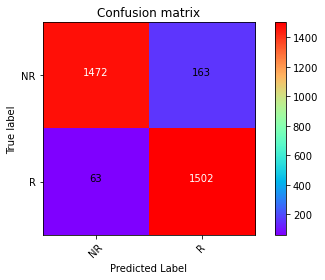

In [243]:
class_names=["NR","R"]
print(__doc__)

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.rainbow):
    """This function prints and plots the confusion matrix.
       Normalization can be applied by setting 'normalize = True'"""
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",color="white" if cm[i,j]>thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
# Compute confusion matrix
cnf_matrix=confusion_matrix(y_test_le,preds)
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title='Confusion matrix')

#Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix,classes=class_names,normalize=True, title='Normalized Confusion matrix')
plt.show()

In [244]:
from sklearn.metrics import accuracy_score
accuracy_score((y_test_le),preds)

0.929375

In [245]:
from sklearn.metrics import recall_score
recall_score((y_test_le),preds)

0.9597444089456869

In [246]:
from sklearn.metrics import precision_score
precision_score((y_test_le),preds)

0.9021021021021021

In [247]:
from sklearn.metrics import f1_score
f1_score((y_test_le),preds)

0.930030959752322

<b>Evaluation Metrics</b>

In [248]:
from sklearn.metrics import classification_report
lst=(classification_report((y_test_le),preds, target_names=class_names))
print(lst)

              precision    recall  f1-score   support

          NR       0.96      0.90      0.93      1635
           R       0.90      0.96      0.93      1565

    accuracy                           0.93      3200
   macro avg       0.93      0.93      0.93      3200
weighted avg       0.93      0.93      0.93      3200



<h1>Naive bayes</h1>

In [249]:
from sklearn.naive_bayes import GaussianNB
nav_clf = GaussianNB()
nav_clf.fit(X_train_s, y_train_le)
predict_nav = nav_clf.predict(X_test_s)
#pred1 = (predict_nav >= 0.5).astype("int").ravel()
accuracy_score(y_test_le, predict_nav)

#naive=(classification_report((y_test_le),pred1, target_names=class_names))

0.5109375

In [250]:
precision_score((y_test_le),predict_nav)


0.5

In [251]:
recall_score((y_test_le),predict_nav)


0.9968051118210862

In [252]:
f1_score((y_test_le),predict_nav)

0.6659551760939167

In [253]:
from sklearn.neighbors import KNeighborsClassifier

KN = KNeighborsClassifier()
KN.fit(X_train_s, y_train_le)
predict_kn = KN.predict(X_test_s)
accuracy_score(y_test_le, predict_kn)
#pred2 = (predict_kn >= 0.5).astype("int").ravel()
#knnn=(classification_report((y_test_le),pred2, target_names=class_names))

0.7615625

In [254]:
precision_score((y_test_le),predict_kn)


0.7353286384976526

In [255]:
recall_score((y_test_le),predict_kn)


0.8006389776357827

In [256]:
f1_score((y_test_le),predict_kn)

0.7665952890792291

In [257]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train_s, y_train_le)
predict_log = log_reg.predict(X_test_s)
accuracy_score(y_test_le, predict_log)
#pred3 = (predict_log >= 0.5).astype("int").ravel()
#logi=(classification_report((y_test_le),pred3, target_names=class_names))


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.518125

In [258]:
precision_score((y_test_le),predict_log)

0.504108610217935

In [259]:
recall_score((y_test_le),predict_log)


0.9015974440894569

In [260]:
f1_score((y_test_le),predict_log)

0.6466544454628781

In [261]:
from sklearn.ensemble import RandomForestClassifier

In [262]:
rand_clf = RandomForestClassifier()
rand_clf.fit(X_train_s, y_train_le)
predict = rand_clf.predict(X_test_s)
accuracy_score(y_test_le, predict)
#pred4 = (predict >= 0.5).astype("int").ravel()
#rf=(classification_report((y_test_le),pred4, target_names=class_names))


0.8903125

In [263]:
precision_score((y_test_le),predict)

0.852906976744186

In [264]:
recall_score((y_test_le),predict)

0.9373801916932908

In [265]:
f1_score((y_test_le),predict)

0.8931506849315068

In [266]:
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train_s, y_train_le)
predict_dt = dt_clf.predict(X_test_s)
accuracy_score(y_test_le, predict_dt)
#pred3 = (predict_log >= 0.5).astype("int").ravel()
print((classification_report((y_test_le),predict_dt, target_names=class_names)))


              precision    recall  f1-score   support

          NR       0.85      0.87      0.86      1635
           R       0.86      0.83      0.85      1565

    accuracy                           0.85      3200
   macro avg       0.85      0.85      0.85      3200
weighted avg       0.85      0.85      0.85      3200



In [267]:
precision_score((y_test_le),predict_dt)

0.859776168531929

In [268]:
recall_score((y_test_le),predict_dt)

0.8345047923322684

In [269]:
f1_score((y_test_le),predict_dt)

0.8469520103761349

In [270]:
from sklearn.ensemble import GradientBoostingClassifier
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train_s, y_train_le)
predict_grad = grad_clf.predict(X_test_s)
accuracy_score(y_test_le, predict_grad)

0.8121875

In [271]:
precision_score((y_test_le),predict_grad)

0.7845336481700118

In [272]:
recall_score((y_test_le),predict_grad)

0.8492012779552716

In [273]:
f1_score((y_test_le),predict_grad)

0.815587603559374

In [274]:
from sklearn import svm
svm_clf = svm.SVC()
svm_clf.fit(X_train_s, y_train_le)
predict_svm=svm_clf.predict(X_test_s)
accuracy_score(y_test_le, predict_svm)

0.6928125

In [275]:
precision_score((y_test_le),predict_svm)

0.6711764705882353

In [276]:
recall_score((y_test_le),predict_svm)

0.729073482428115

In [277]:
f1_score((y_test_le),predict_svm)

0.698928024502297

In [282]:
sample_text1 = "May ISIS rule the US in future."
sample_text2 = "I had bread in the breakfast"
samples = [sample_text1,sample_text2]
samples_tokens = tk.texts_to_sequences(samples)
samples_paddings=pad_sequences(samples_tokens,maxlen=maxpadlen,padding='post')
samples_rounded_predictions = model.predict(samples_paddings)
#classes_x=np.argmax(samples_rounded_predictions,axis=1)
values = (samples_rounded_predictions >= 0.5).astype("int").ravel()
print(samples_rounded_predictions)
print(values)

[[0.12]
 [0.92]]
[0 1]
